## Clustering
Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many applications.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create Data

In [3]:
n_clusters = 6
n_samples = 250

To generate our data we're going to pick 6 random points, which we'll call centroids, and for each point we're going to add 250 random points aboiut it

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [7]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [8]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [9]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [10]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples: (i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5)
        ax.plot(*centroid, markersize=10, marker="x", color='m', mew=2)

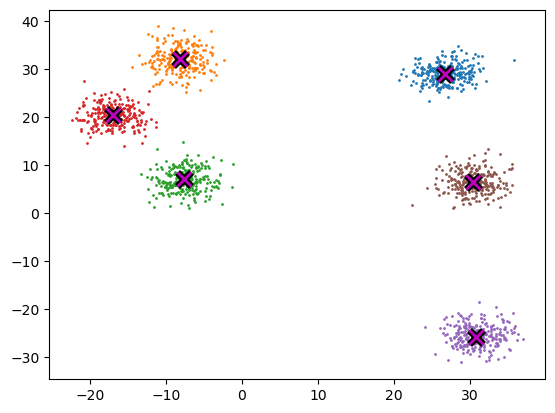

In [11]:
plot_data(centroids, data, n_samples)

## Mean shift
Most people that have come across clustering algorithms have learnt about k-means. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:

- It doesn't require selecting the number of clusters in advance, but instead just requires a bandwidth to be specified, which can be easily chosen automatically
- It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:

- For each data point x in the sample X, find the distance between that point x and every other point in X
- Create weights for each point in X by using the Gaussian kernel of that point's distance to x
    - This weighting approach penalizes points further away from x
    - The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian
- Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [13]:
midp = data.mean(0)
midp

tensor([ 9.222, 11.604])

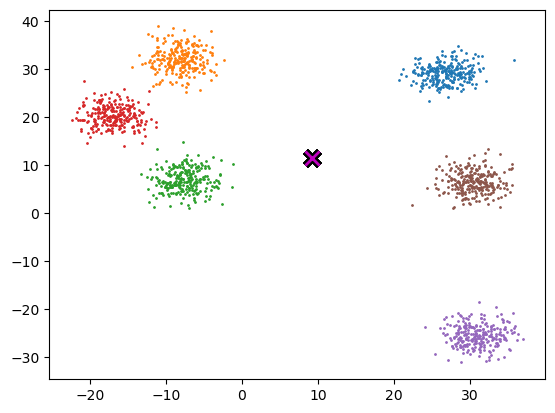

In [14]:
plot_data([midp]*6, data, n_samples)

Mean of all points

So here's the definition of the guassian kernel, which you may remember from high school... 

In [36]:
def guassian(d, bw):
    return torch.exp(-0.5 * ((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [16]:
def plot_func(f):
    x = torch.linspace(0, 10, 100)
    plt.plot(x, f(x))

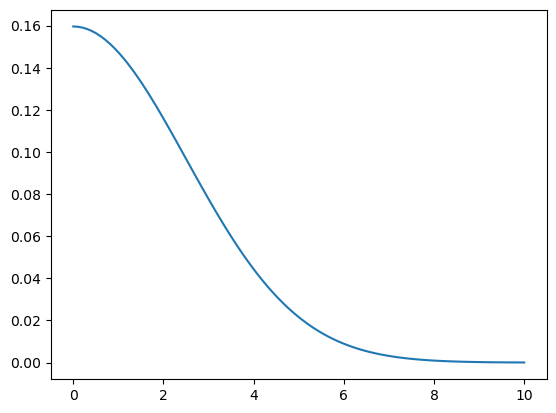

In [20]:
plot_func(partial(guassian, bw=2.5))

Easy way to choose bandwidth is to find which bandwidth covers the one third of the data.

In [21]:
def tri(d, i): return (-d+i).clamp_min(0)/i

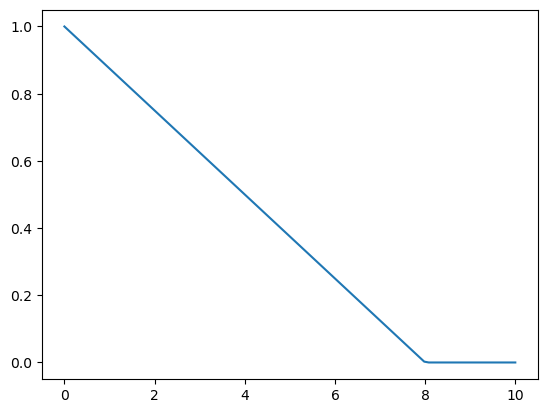

In [23]:
plot_func(partial(tri, i=8))

In [24]:
X = data.clone()
x = data[0]

In [25]:
x

tensor([26.204, 26.349])

In [26]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [28]:
x-X[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [31]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8], dist.shape

(tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002]),
 torch.Size([1500]))

In [32]:
weight = guassian(dist, 2.5)
weight, weight.shape

(tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000]),
 torch.Size([1500]))

In [33]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [35]:
weight[:, None] * X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [37]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = guassian(dist, 2.5)
        X[i] = (weight[:, None]*X).sum(0)/weight.sum()

In [38]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [39]:
%time X=meanshift(data)

CPU times: user 994 ms, sys: 15.9 ms, total: 1.01 s
Wall time: 1.01 s


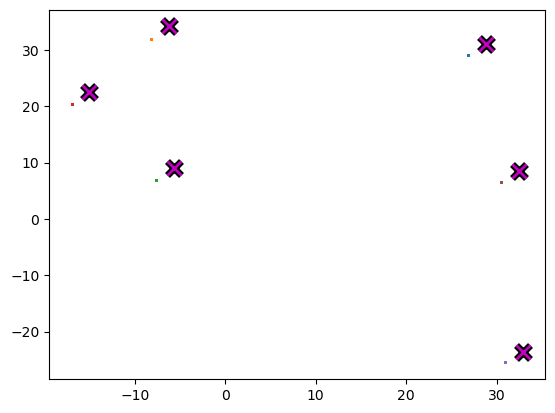

In [40]:
plot_data(centroids+2, X, n_samples)

## Animation

In [41]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [ ]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm
To truly acclerate the algorithm, we need to be performing updats on a batch of points per iteration, instead of just on as w are doing.

In [43]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))